In [11]:
import mne
import matplotlib.pyplot as plt
import numpy as np
file = "physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names
#get target
print("------------EVENTS-------------")
print(data.annotations.description)
print("--------EVENT START TIME--------")
print(data.annotations.onset)
print("---------EVENT DURATION----------")
print(data.annotations.duration)

Extracting EDF parameters from /home/andre/Desktop/MachineLearning/Movement_EEG/physionet.org/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
------------EVENTS-------------
['T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1'
 'T0' 'T2' 'T0' 'T1' 'T0' 'T2' 'T0' 'T2' 'T0' 'T1' 'T0' 'T1' 'T0' 'T2'
 'T0' 'T1']
--------EVENT START TIME--------
[  0.    4.2   8.3  12.5  16.6  20.8  24.9  29.1  33.2  37.4  41.5  45.7
  49.8  54.   58.1  62.3  66.4  70.6  74.7  78.9  83.   87.2  91.3  95.5
  99.6 103.8 107.9 112.1 116.2 120.4]
---------EVENT DURATION----------
[4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1
 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1 4.2 4.1]


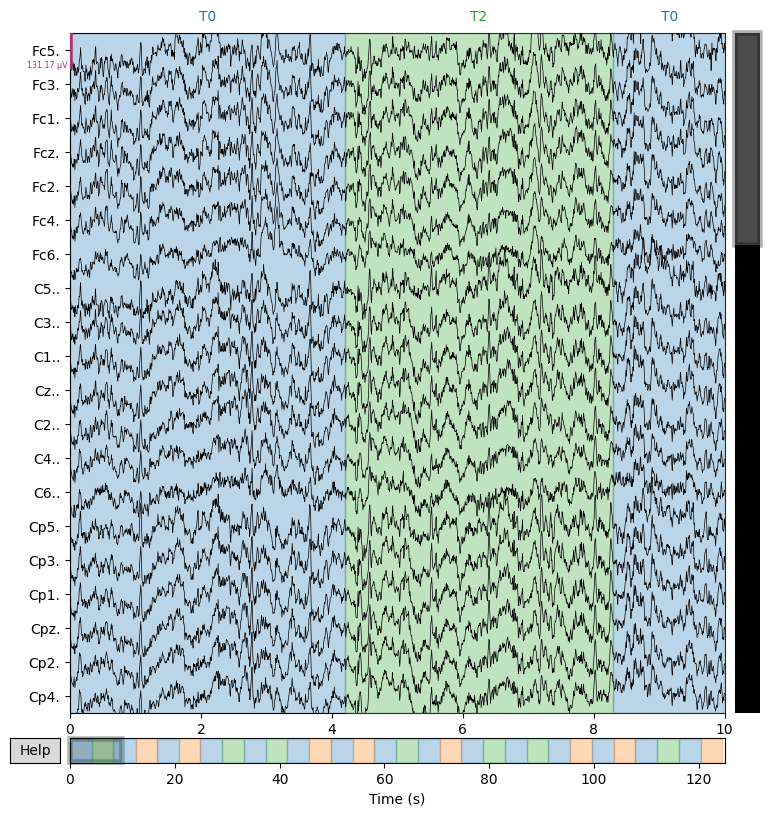

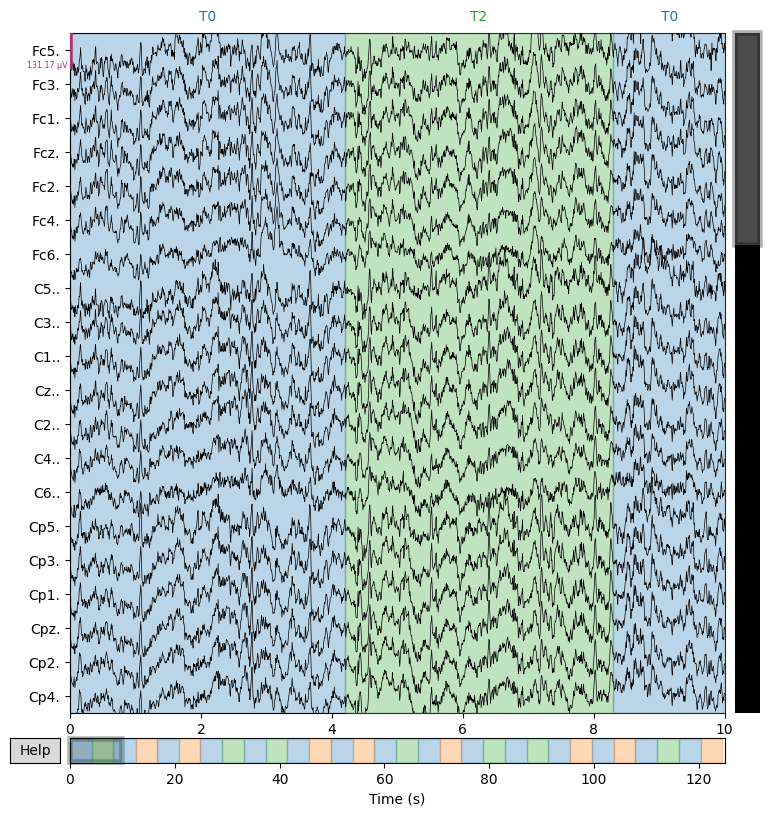

In [12]:
data.plot(scalings='auto', title='Data from arrays')

In [13]:

contador = 0
start_t = data.annotations.onset
yData = []
#getting the target
for i in range(0,raw_data.shape[1]):
    time = i/160
    if contador < data.annotations.description.shape[0]:
        if time >= start_t[contador]:
            contador = contador + 1
    yData.append(data.annotations.description[contador-1])
yData = np.array(yData)



In [14]:
#encode y labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(yData)
yData = le.transform(yData)

In [15]:
index80 = int(0.8 * raw_data.shape[1])
Xtrain = raw_data[0:64, 0:index80].T
Xtest = raw_data[0:64, index80:].T
ytrain = yData[0:index80]
ytest = yData[index80:]

In [16]:
Xtrain.shape[1]

64

In [17]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN


model = Sequential()
model.add(SimpleRNN(64, input_shape=(Xtrain.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.fit(Xtrain, ytrain, epochs=100, batch_size=1028, verbose="auto")


Epoch 1/100
16/16 [==============================] - 1s 17ms/step - loss: 0.5755 - accuracy: 0.2460
Epoch 2/100
16/16 [==============================] - 0s 22ms/step - loss: 0.5759 - accuracy: 0.2460
Epoch 3/100
16/16 [==============================] - 0s 19ms/step - loss: 0.5759 - accuracy: 0.2460
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.5758 - accuracy: 0.2460
Epoch 5/100
16/16 [==============================] - 0s 22ms/step - loss: 0.5764 - accuracy: 0.2460
Epoch 6/100
16/16 [==============================] - 0s 21ms/step - loss: 0.5758 - accuracy: 0.2460
Epoch 7/100
16/16 [==============================] - 0s 20ms/step - loss: 0.5757 - accuracy: 0.2460
Epoch 8/100
16/16 [==============================] - 0s 17ms/step - loss: 0.5753 - accuracy: 0.2460
Epoch 9/100
16/16 [==============================] - 0s 15ms/step - loss: 0.5769 - accuracy: 0.2460
Epoch 10/100
16/16 [==============================] - 0s 16ms/step - loss: 0.5753 - accuracy: 0.2460